In [2]:
import pretty_midi
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
from os import listdir
import glob
import midi_manipulation

np.set_printoptions(precision=4, suppress=True)

%matplotlib inline

In [3]:
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    songs = []
    for f in files:
        try:
            song = np.array(midi_manipulation.midiToNoteStateMatrix(f))
            #if np.array(song).shape[0] > 50:
            songs.append(song)
        except Exception as e:
            raise e           
    return songs

In [4]:
def get_chromas(songs):
    chromas = []
    for song in songs: 
        chroma = np.zeros(shape=(np.shape(song)[0], 12))
        for i in range(np.shape(song)[0]):
            for j in range(78):
                if song[i][j] == 1:
                    chroma[i][np.mod(j,12)] += 1
        chromas.append(chroma)
                
    return chromas

In [5]:
midi_path = 'example'

In [6]:
song = get_songs(midi_path)

In [7]:
chroma = get_chromas(song)

In [8]:
print(np.shape(chroma[0]))

(1125, 12)


In [9]:
chroma[0]

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
chroma[0] = chroma[0].transpose()

In [11]:
print(chroma[0].shape)

(12, 1125)


In [12]:
chroma[0] = chroma[0][:12, :100]

In [23]:
print(chroma[0].shape)

(12, 100)


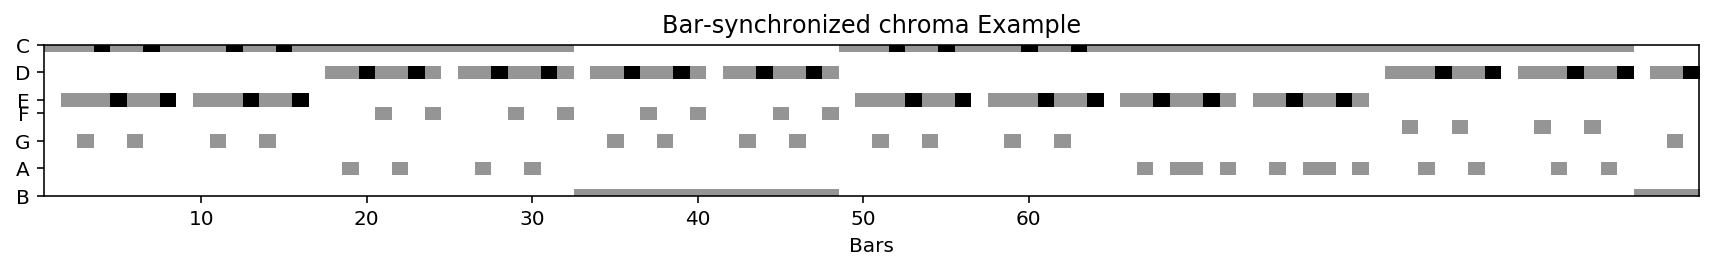

In [15]:
plt.figure(figsize=(12, 2))
plt.imshow(chroma[0], aspect='auto', interpolation='nearest', cmap='Greys')
plt.title('Bar-synchronized chroma Example')
plt.yticks([0,2,4,5,7,9,11], ['C','D','E','F','G','A','B'])
plt.xticks(range(9,60,10),range(10,70,10))
plt.xlabel('Bars')
plt.tight_layout()

In [36]:
# Constants

"""Radiuses of different circles (defined such to reflect the
tonal distance through the euclidian distance on tonnetz vectors)
"""

r_fifth = 1.
r_minor_thirds = 1.
r_major_thirds = 0.5

def _make_tonnetz_matrix():
    """Return the tonnetz projection matrix."""
    pi = np.pi
    chroma = np.arange(12)

    # Define each row of the transform matrix
    fifth_x = r_fifth*(np.sin((7*pi/6) * chroma))
    fifth_y = r_fifth*(np.cos((7*pi/6) * chroma))
    minor_third_x = r_minor_thirds*(np.sin(3*pi/2 * chroma))
    minor_third_y = r_minor_thirds*(np.cos(3*pi/2 * chroma))
    major_third_x = r_major_thirds*(np.sin(2*pi/3 * chroma))
    major_third_y = r_major_thirds*(np.cos(2*pi/3 * chroma))

    # Return the tonnetz matrix
    return np.vstack((fifth_x, fifth_y,
                      minor_third_x, minor_third_y,
                      major_third_x, major_third_y))

__TONNETZ_MATRIX = _make_tonnetz_matrix()

def _to_tonnetz(chromagram):
    
    
  #  chromagram = chromagram.transpose()
    """Project a chromagram on the tonnetz.
    Returned value is normalized to prevent numerical instabilities.  
    """
    if np.sum(np.abs(chromagram)) == 0.:
        # The input is an empty chord, return zero. 
        return np.zeros(6)
    
    _tonnetz = np.dot(__TONNETZ_MATRIX, chromagram)
    one_norm = np.sum(np.abs(_tonnetz))  # Non-zero value
    _tonnetz = _tonnetz / float(one_norm) # Normalize tonnetz vector
    return _tonnetz

def distance(a, b):
    """Compute tonnetz-distance between two chromagrams.
    
    ----
    >>> C = np.zeros(12)
    >>> C[0] = 1
    >>> D = np.zeros(12)
    >>> D[2] = 1
    >>> G = np.zeros(12)
    >>> G[7] = 1
    The distance is zero on equivalent chords
    >>> distance(C, C) == 0
    True
    The distance is symetric
    >>> distance(C, D) == distance(D, C)
    True
    >>> distance(C, D) > 0
    True
    >>> distance(C, G) < distance(C, D)
    True
    """
    [a_tonnetz, b_tonnetz] = [_to_tonnetz(x) for x in [a, b]]
    return np.linalg.norm(b_tonnetz - a_tonnetz)

In [37]:
ton = _to_tonnetz(chroma[0])

In [38]:
print(np.shape(ton))

(6, 100)


Text(0.5, 1.0, 'Tonnetz Example')

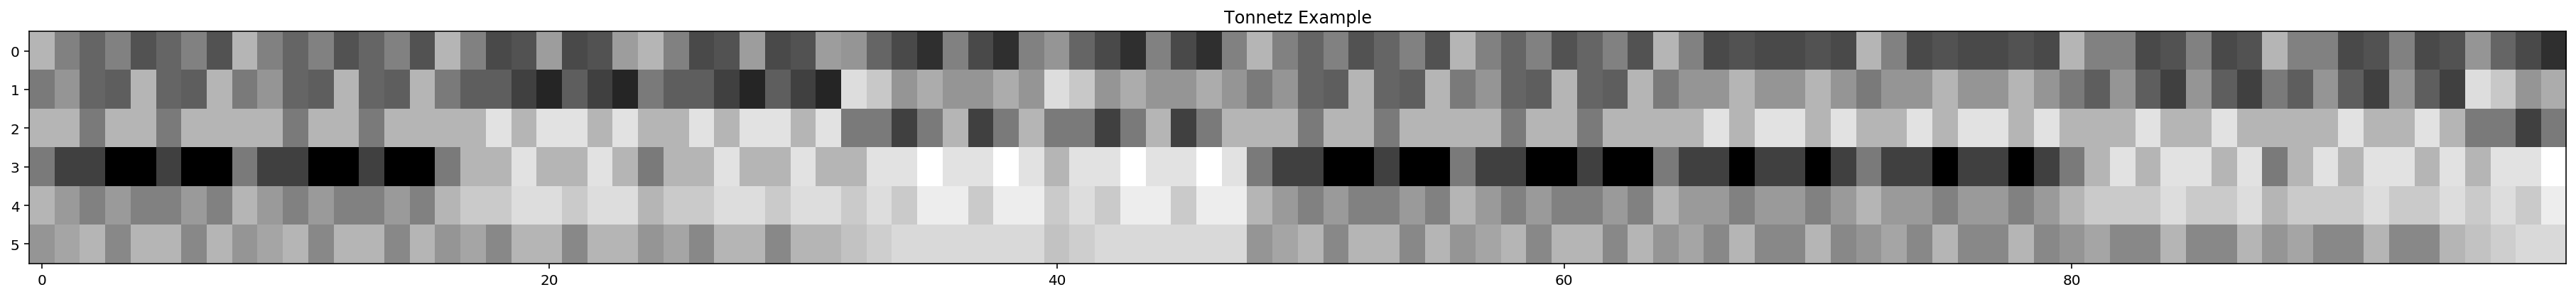

In [39]:

plt.figure(figsize=(32, 3))
plt.imshow(ton, aspect='auto', interpolation='nearest', cmap='Greys')
plt.title('Tonnetz Example')
#plt.tight_layout()